In [48]:
import numpy as np
import pandas as pd
from pmdarima import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_sarimax import backtesting_sarimax
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Carga de datos

In [26]:
df_raw = pd.read_csv("datos_preprocesados.csv", parse_dates=['fecha'], index_col='fecha').asfreq('D')
df = df_raw.copy()
df = df.sort_index()

# Estacionareidad

In [3]:
# Realizar la prueba ADF
result = adfuller(df['demanda'].dropna(), autolag='AIC')  # Reemplaza 'demanda' con el nombre de tu columna

# Mostrar los resultados
print('Estadístico ADF:', result[0])
print('Valor p:', result[1])
print('Número de lags utilizados:', result[2])
print('Número de observaciones:', result[3])
print('Valores críticos:')
for key, value in result[4].items():
    print(f'   {key}: {value:.3f}')

Estadístico ADF: -5.052465765139282
Valor p: 1.7455961251430773e-05
Número de lags utilizados: 26
Número de observaciones: 2069
Valores críticos:
   1%: -3.434
   5%: -2.863
   10%: -2.568


# División del conjunto de datos

In [55]:
# Divisiones de los datos en los conjuntos de entrenamiento y test
end_train = '2023-08-12'

data_train = df.loc[:end_train]
data_test  = df.loc[end_train:]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2019-01-01 00:00:00 --- 2023-08-12 00:00:00  (n=1685)
Dates test       : 2023-08-12 00:00:00 --- 2024-09-26 00:00:00  (n=412)


# Modelo ARIMA

In [77]:
# Función para entrenamiento del modelo ARIMAX. No usa optimizador.

def arima(p, d, q, maxiter):
    forecaster = ForecasterSarimax( regressor=ARIMA(order=(p, d, q), seasonal_order=(0, 0, 0, 0), maxiter=maxiter))
    
    metric, predictions = backtesting_sarimax(
        forecaster         = forecaster,
        y                  = df['demanda'],
        steps              = 1,
        metric             = 'mean_absolute_error',
        initial_train_size = len(data_train),
        fixed_train_size   = False,       
        refit              = False,
        verbose            = False
    )
    return metric.iloc[0]

# Modelo ARIMAX

In [82]:
# Función para entrenamiento del modelo ARIMAX. No usa optimizador.

def arimax(exog_features, p, d, q, maxiter):
    forecaster = ForecasterSarimax( regressor=ARIMA(order=(p, d, q), seasonal_order=(0, 0, 0, 0), maxiter=maxiter))
    
    metric, predictions = backtesting_sarimax(
        forecaster         = forecaster,
        y                  = df['demanda'],
        exog               = df[exog_features],
        steps              = 1,
        metric             = 'mean_absolute_error',
        initial_train_size = len(data_train),
        fixed_train_size   = False,       
        refit              = False,
        verbose            = False
    )
    return metric.iloc[0]
             

# Resultados

In [80]:
exog_features = ['diasem', 'trim', 'festivo']
maxiter = 50

# Definir los rangos para p, d y q
range_values = range(1, 4)  # Esto generará 1, 2, 3
range_values2 = range(1, 2) 

# Crear una lista para almacenar los resultados
results = []

# Iterar sobre los valores de p, d, q
for p in range_values:
    for d in range_values:
        for q in range_values2:
            # Llamar a la función arimax con los parámetros actuales
            metrica = arimax(exog_features, p, d, q, maxiter)
            
            # Si la métrica es un DataFrame o una Serie, extrae el valor escalar
            if isinstance(metrica, pd.Series):
                metrica_value = metrica.iloc[0]  # Extrae el primer valor
            else:
                metrica_value = metrica  # Asume que ya es un valor escalar

            # Imprimir el resultado
            print(f"Para p, d, q = {p}, {d}, {q} la métrica es {metrica_value}")

            # Agregar los resultados a la lista
            results.append({'p': p, 'd': d, 'q': q, 'MAE': metrica_value})

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Guardar el DataFrame en un archivo Excel
results_df.to_excel('resultados_arimax_3.xlsx', index=False)


  0%|          | 0/411 [00:00<?, ?it/s]

Para p, d, q = 1, 1, 1 la métrica es 1135.6786522360646


  0%|          | 0/411 [00:00<?, ?it/s]

Para p, d, q = 1, 2, 1 la métrica es 1142.4766520669855


  0%|          | 0/411 [00:00<?, ?it/s]

Para p, d, q = 1, 3, 1 la métrica es 1427.70219907802


  0%|          | 0/411 [00:00<?, ?it/s]

Para p, d, q = 2, 1, 1 la métrica es 1000.2378879962251


  0%|          | 0/411 [00:00<?, ?it/s]

Para p, d, q = 2, 2, 1 la métrica es 1102.0336217058693


  0%|          | 0/411 [00:00<?, ?it/s]

Para p, d, q = 2, 3, 1 la métrica es 1390.6290939438786


  0%|          | 0/411 [00:00<?, ?it/s]

Para p, d, q = 3, 1, 1 la métrica es 945.8763212909072


  0%|          | 0/411 [00:00<?, ?it/s]

Para p, d, q = 3, 2, 1 la métrica es 1055.838184666339


  0%|          | 0/411 [00:00<?, ?it/s]

Para p, d, q = 3, 3, 1 la métrica es 1321.3884306469079


# Representación gráfica de resultados

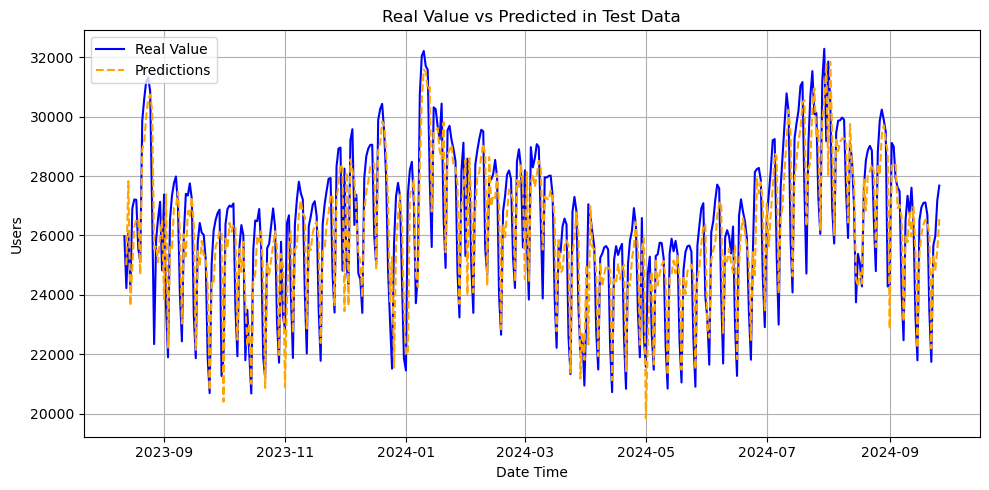

In [44]:
# Plot predictions vs real value
# ======================================================================================
plt.figure(figsize=(10, 5))  # Define el tamaño de la figura

# Graficar los valores reales
plt.plot(data_test.index, data_test['demanda'], label="Real Value", color='blue', linestyle='-')

# Graficar las predicciones
plt.plot(predictions.index, predictions['pred'], label="Predictions", color='orange', linestyle='--')

# Configurar el título y las etiquetas
plt.title("Real Value vs Predicted in Test Data")
plt.xlabel("Date Time")
plt.ylabel("Users")

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.grid()  # Añadir cuadrícula para mejor visualización
plt.tight_layout()  # Ajustar el layout
plt.show()
